In [454]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from pandas.tseries.offsets import MonthEnd

In [455]:
def quintiles(inser):
    outser = pd.qcut(inser, q=5, labels=range(1,6))
    return outser

# Trading Signal Model using Value and MOM factos

**by Oscar Chim**

Download the sas file from CRSP and convert it to feather.

In [456]:
#stocks_sas = pd.read_sas("qdvwinhtacahrfour.sas7bdat")
#stocks = stocks_sas.to_feather("stocks.feather", compression = "zstd")
#pd.read_feather("stocks.feather")

# IDEA:

We will use Fama-Macbeth (FM) Regression to estimate stocks's future return, and use these forcasts to form a trading strategy.

Procedure:

1. At the beginning of year 0 (e.g. beginning of 2000) ,  only select top 50% market cap stocks by looking at their previous year (e.g. end of 1999)'s market cap. We use lagged market cap to avoid look-ahead bias.
2. Run FM Regression on the last 30 year data (1971-2000).

More specifically, the FM regression: 
    
    R @t = b0 + b1* E/P @t-1 + b2* VOL @t-1 + b3* MOM @t-1, where MOM = sum of the first 11 month returns in the past 13 months. 

- We use E/P ratio because its a metric for "value"; a low "value" generally implies a higher future return.
- We use volume as a proxy of liquidity. A high liquidity stocks can be a signal of quality, and a high quality stock is usually associate with high returns.
- Momentum as a technical indicator. The highest momentum stock is expected to be a winner, and thus is it expected to persist in future performance.

3. Use the model to predict each stock's monthly returns in next year (e.g. 2001), so each year has 12 forecasts for each stock.
4. Split the stocks into 5 groups using the forecasted monthly returns.
5. Long only the highest forecasted return group. Components in the portfolio are adjusted every month.
6. At the beginning of next year, repeat step 1 to 2 but using 1972-2001 data to update the model, and so on.

Detailed explanation:

We will only look at the stocks belong to the top 50% market value since low market cap stocks are more likely to associate with bad quality than high cap stocks, so first we want to exclude all the stocks in low 50% perceniile for each month (using lagged MV). In the beginning of each year, we will apply FM regression to the past 30 year stock data to generate coefficients, b0, b1, b2. And then we will use the coefficients to estimate the monthly return for each stock for the next year. For example, we will use the 1971 to 2000 data to build our model and use the model to forecast the monthly return of stocks in 2001. We will then seperate stocks into 5 groups based on the level of its forcasted return and long only the highest forecasted return group (group 5) as an equally weighted portfolio. In the beginning of the next year, we will repeat the same FM regression, compute the new coefficients, apply the the computed coefficients to monthly data to generate forecasted monthly return, and re-select stocks. The back-test is conducted from 2001 to 2021.

# Cleaning Data

In [457]:
capiq = pd.read_feather("compustat_annual.feather")
stocks = pd.read_feather("crsp_monthly_stocks.feather")

In [458]:
stocks

,PERMNO,DATE,SHRCD,EXCHCD,SICCD,PRC,VOL,RET,SHROUT
0,10000.0,1985-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10000.0,1986-01-31,10.0,3.0,3990.0,-4.375000,1771.0,NaN,3680.0
2,10000.0,1986-02-28,10.0,3.0,3990.0,-3.250000,828.0,-0.257143,3680.0
3,10000.0,1986-03-31,10.0,3.0,3990.0,-4.437500,1078.0,0.365385,3680.0
4,10000.0,1986-04-30,10.0,3.0,3990.0,-4.000000,957.0,-0.098592,3793.0
...,...,...,...,...,...,...,...,...,...
4285980,93436.0,2022-02-28,11.0,3.0,9999.0,870.429993,4609541.0,-0.070768,1033508.0
4285981,93436.0,2022-03-31,11.0,3.0,9999.0,1077.599976,5742614.0,0.238009,1035976.0
4285982,93436.0,2022-04-29,11.0,3.0,9999.0,870.760010,5046142.0,-0.191945,1036010.0
4285983,93436.0,2022-05-31,11.0,3.0,9999.0,758.260010,6470842.0,-0.129197,1036010.0


The code cleans up the stock data.  The code below does the following:

1. Shift the date so that it is always the last day of the month, rather than the last trading day.  This will make it easier to merge in with other datasets.
2. Take the absolute value of the closing price.  For shares that don't trade, CRSP sets the price equal to the closing bid-ask midpoint, but it makes the price negative as a warning about this.
3. Define market value (MV) as the product of shares outstanding and closing price.
4. Drop shares outstanding, which we won't use again, and the share code.  We use the share code when we download data from WRDS.  Selecting share codes of 10 or 11 means that we will be downloading common equity and not other securities (ETFs, REITS, etc.).  Also drop EXCHCD, SICCD, PRC, and VOL to make the dataframe easier to display.
5. Set the index to PERMNO/DATE.
6. Sort by the index.
7. Look at the dataframe.

In [459]:
#stocks= stocks.loc[stocks["DATE"]>="2000-01-01"]
#capiq= capiq.loc[capiq["DATADATE"]>="2000-01-01"]
stocks = stocks.loc[(stocks["SHRCD"]== 10.0) | (stocks["SHRCD"] == 11.0)]
stocks =stocks.drop(columns=["SHRCD","EXCHCD","SICCD"])
stocks["DATE"] = stocks["DATE"] + MonthEnd(0)
stocks["PRC"] = np.abs(stocks["PRC"])
stocks["MV"] = stocks["SHROUT"]*stocks["PRC"]
stocks.drop(columns=["SHROUT","PRC"], inplace=True)
#stocks=stocks.set_index(["PERMNO","DATE"]).sort_index()
stocks = stocks.set_index(["PERMNO","DATE"]).sort_index()

In [460]:
capiq.head()

,DATADATE,FYEAR,LPERMNO,AT,CEQ,LT,PSTK,SEQ,IB,CAPX
0,1970-12-31,1970.0,25881.0,33.450,10.544,22.906,0.000,10.544,1.878,2.767
1,1971-12-31,1971.0,25881.0,29.330,8.381,20.948,0.000,8.382,0.138,1.771
2,1972-12-31,1972.0,25881.0,19.907,7.021,12.886,0.000,7.021,1.554,1.254
3,1973-12-31,1973.0,25881.0,21.771,8.567,13.204,0.000,8.567,1.863,1.633
4,1974-12-31,1974.0,25881.0,25.638,9.843,15.381,0.414,10.257,1.555,1.313


The code does the following:

 1. Rename LPERMNO as PERMNO.
 2. Set all the dates to the last calendar of the month instead of all trading date.
 3. Assume and set the publication date for the financial data 6 months after the company's fiscal year.
 4. Set indices and sort the indices.

In [461]:
capiq.rename(columns = {"LPERMNO":"PERMNO"}, inplace = True)
capiq["DATE"] = capiq["DATADATE"] + MonthEnd(0)
capiq=capiq.drop(columns = ["DATADATE","FYEAR","PSTK","CEQ","LT","CAPX","AT"])

#publication date (lagged by 6 months)
capiq["DATE"] = capiq["DATE"] + MonthEnd(6) 

capiq=capiq.set_index(["PERMNO","DATE"]).sort_index()

In [462]:
capiq

SEQ        IB
PERMNO  DATE                           
10000.0 1987-04-30      0.418    -0.730
10001.0 1986-12-31      5.432     0.669
        1987-12-31      5.369     0.312
        1988-12-31      5.512     0.542
        1989-12-31      6.321     1.208
...                       ...       ...
93436.0 2018-06-30   4237.312 -1961.400
        2019-06-30   4923.243  -976.091
        2020-06-30   6618.000  -862.000
        2021-06-30  22225.000   721.000
        2022-06-30  30189.000  5519.000

[302593 rows x 2 columns]

We now need to merge these data.  Unfortunately, the data occasionally have multiple rows with the same PERMNO and DATE.  So we are going to have to eliminate duplicate PERMNO/DATE pairs to make sure no duplications.

My assumption is that we should assume that if there is more than one PERMNO on the same date, then the bigger MV/SEQ one is probably more important and therefore more likely to be correct.

I am therefore going to sort the dataframe in ascending order by PERMNO, then in ascending order by DATE, and then in descending order by size (either MV or SEQ).  This is how I did it:

In [463]:
stocks = stocks.sort_values(by = ['PERMNO','DATE','MV'], ascending = [True, True, False])
capiq  = capiq.sort_values(by = ['PERMNO','DATE','SEQ'], ascending = [True, True, False])
stocks = stocks.groupby(['PERMNO','DATE']).head(1)
capiq  = capiq.groupby(['PERMNO','DATE']).head(1)

In [464]:
stocks

VOL       RET            MV
PERMNO  DATE                                         
10000.0 1986-01-31     1771.0       NaN  1.610000e+04
        1986-02-28      828.0 -0.257143  1.196000e+04
        1986-03-31     1078.0  0.365385  1.633000e+04
        1986-04-30      957.0 -0.098592  1.517200e+04
        1986-05-31     1074.0 -0.222656  1.179386e+04
...                       ...       ...           ...
93436.0 2022-02-28  4609541.0 -0.070768  8.995964e+08
        2022-03-31  5742614.0  0.238009  1.116368e+09
        2022-04-30  5046142.0 -0.191945  9.021161e+08
        2022-05-31  6470842.0 -0.129197  7.855650e+08
        2022-06-30  6684634.0 -0.111888  6.976698e+08

[3205397 rows x 3 columns]

# Adding a Momentum Variable

In [465]:
temp = pd.DataFrame(stocks['RET'].groupby('PERMNO').rolling(11).mean())
temp['MOM'] = temp['RET'].groupby('PERMNO').shift(2)
temp = temp.drop('RET', axis = 1)
temp.index = stocks.index

In [466]:
stocks = stocks.merge(temp['MOM'], how='left', on=['PERMNO','DATE'])

In [467]:
stocks

VOL       RET            MV       MOM
PERMNO  DATE                                                   
10000.0 1986-01-31     1771.0       NaN  1.610000e+04       NaN
        1986-02-28      828.0 -0.257143  1.196000e+04       NaN
        1986-03-31     1078.0  0.365385  1.633000e+04       NaN
        1986-04-30      957.0 -0.098592  1.517200e+04       NaN
        1986-05-31     1074.0 -0.222656  1.179386e+04       NaN
...                       ...       ...           ...       ...
93436.0 2022-02-28  4609541.0 -0.070768  8.995964e+08  0.035781
        2022-03-31  5742614.0  0.238009  1.116368e+09  0.038975
        2022-04-30  5046142.0 -0.191945  9.021161e+08  0.033560
        2022-05-31  6470842.0 -0.129197  7.855650e+08  0.049548
        2022-06-30  6684634.0 -0.111888  6.976698e+08  0.042890

[3205397 rows x 4 columns]

Now we exclude the lowest 50 percentile stocks.

In [468]:
def quintiles(inser):
    outser = pd.qcut(inser, q=4, labels=range(1,5))
    return outser

In [469]:
stock1=stocks.reorder_levels(["DATE","PERMNO"]).sort_index()
stock1["MVQ"]=stock1["MV"].groupby(["DATE"]).apply(quintiles)
stock1 = stock1.reorder_levels(["PERMNO","DATE"]).sort_index()
stock1["Lagged MVQ"]= stock1["MVQ"].groupby("PERMNO").shift()
stocks= stock1.loc[(stock1["Lagged MVQ"]>=3) | (stock1["Lagged MVQ"].isna())]
#If some stock is newly issued or on the first date of the data , they are all the 1st observation so no MV is observed. 
#We will take them into consideration when forming portfolios.
stocks0 = stocks #saved the dataset and use it at the end as a benchmark
stocks

VOL       RET            MV       MOM MVQ Lagged MVQ
PERMNO  DATE                                                                  
10000.0 1986-01-31     1771.0       NaN  1.610000e+04       NaN   2        NaN
10001.0 1986-01-31      667.0       NaN  6.033125e+03       NaN   1        NaN
10002.0 1986-01-31     1284.0       NaN  1.365938e+04       NaN   2        NaN
        1998-07-31      173.0 -0.012500  1.258470e+05  0.051774   3          3
        1998-08-31      223.0 -0.164557  1.051380e+05  0.052068   3          3
...                       ...       ...           ...       ...  ..        ...
93436.0 2022-02-28  4609541.0 -0.070768  8.995964e+08  0.035781   4          4
        2022-03-31  5742614.0  0.238009  1.116368e+09  0.038975   4          4
        2022-04-30  5046142.0 -0.191945  9.021161e+08  0.033560   4          4
        2022-05-31  6470842.0 -0.129197  7.855650e+08  0.049548   4          4
        2022-06-30  6684634.0 -0.111888  6.976698e+08  0.042890   4          4

[1653166 rows x 6 columns]

Now I merge the capiq and stocks data into 1 dataframe.

In [470]:
stocks = stocks.merge(capiq, how='left', on=['PERMNO','DATE'])
stocks

VOL       RET            MV       MOM MVQ  \
PERMNO  DATE                                                          
10000.0 1986-01-31     1771.0       NaN  1.610000e+04       NaN   2   
10001.0 1986-01-31      667.0       NaN  6.033125e+03       NaN   1   
10002.0 1986-01-31     1284.0       NaN  1.365938e+04       NaN   2   
        1998-07-31      173.0 -0.012500  1.258470e+05  0.051774   3   
        1998-08-31      223.0 -0.164557  1.051380e+05  0.052068   3   
...                       ...       ...           ...       ...  ..   
93436.0 2022-02-28  4609541.0 -0.070768  8.995964e+08  0.035781   4   
        2022-03-31  5742614.0  0.238009  1.116368e+09  0.038975   4   
        2022-04-30  5046142.0 -0.191945  9.021161e+08  0.033560   4   
        2022-05-31  6470842.0 -0.129197  7.855650e+08  0.049548   4   
        2022-06-30  6684634.0 -0.111888  6.976698e+08  0.042890   4   

                   Lagged MVQ      SEQ      IB  
PERMNO  DATE                                    
10000.0 1986-01-31        NaN      NaN     NaN  
10001.0 1986-01-31        NaN      NaN     NaN  
10002.0 1986-01-31        NaN      NaN     NaN  
        1998-07-31          3      NaN     NaN  
        1998-08-31          3      NaN     NaN  
...                       ...      ...     ...  
93436.0 2022-02-28          4      NaN     NaN  
        2022-03-31          4      NaN     NaN  
        2022-04-30          4      NaN     NaN  
        2022-05-31          4      NaN     NaN  
        2022-06-30          4  30189.0  5519.0  

[1653166 rows x 8 columns]

To see what exactly happened, I first only look at the APPL stock.

- AAPL's fiscal year ends in Sept (9/31). I assume the financial statements and data will surely be released 6 months later on March (3/31). The SEQ and IB are aligned with my assumption now. 

In [471]:
AAPL=stocks.loc[14593]
AAPL.tail(24)

,VOL,RET,MV,MOM,MVQ,Lagged MVQ,SEQ,IB
DATE,,,,,,,,
2020-07-31,7543023.0,0.165132,1.817316e+09,0.048177,4,4,NaN,NaN
2020-08-31,11844232.0,0.216309,2.206911e+09,0.054631,4,4,NaN,NaN
2020-09-30,38816274.0,-0.102526,1.966079e+09,0.071149,4,4,NaN,NaN
2020-10-31,28938282.0,-0.060012,1.850816e+09,0.084181,4,4,NaN,NaN
2020-11-30,21197000.0,0.095490,2.024065e+09,0.064798,4,4,NaN,NaN
2020-12-31,23205317.0,0.114574,2.232279e+09,0.052304,4,4,NaN,NaN
2021-01-31,22434811.0,-0.005502,2.215357e+09,0.052004,4,4,NaN,NaN
2021-02-28,18332944.0,-0.079532,2.035725e+09,0.057510,4,4,NaN,NaN
2021-03-31,26489849.0,0.007340,2.038232e+09,0.067402,4,4,65339.0,57411.0


We are going to fill in all the missing values so that we can refer to the latest data released in March every year.

In [472]:
stocks["SEQ"]=stocks["SEQ"].groupby('PERMNO').fillna(method='pad', limit=15)
stocks["IB"]=stocks["IB"].groupby('PERMNO').fillna(method='pad', limit=15)

Let's look at the AAPL subset and check if anything is wrong. The data released in 2021-03-31 is observed from 2021-03-31 to 2022-02-28. The look ahead bias is avoided.

In [473]:
AAPL=stocks.loc[14593]
AAPL.tail(24)

,VOL,RET,MV,MOM,MVQ,Lagged MVQ,SEQ,IB
DATE,,,,,,,,
2020-07-31,7543023.0,0.165132,1.817316e+09,0.048177,4,4,90488.0,55256.0
2020-08-31,11844232.0,0.216309,2.206911e+09,0.054631,4,4,90488.0,55256.0
2020-09-30,38816274.0,-0.102526,1.966079e+09,0.071149,4,4,90488.0,55256.0
2020-10-31,28938282.0,-0.060012,1.850816e+09,0.084181,4,4,90488.0,55256.0
2020-11-30,21197000.0,0.095490,2.024065e+09,0.064798,4,4,90488.0,55256.0
2020-12-31,23205317.0,0.114574,2.232279e+09,0.052304,4,4,90488.0,55256.0
2021-01-31,22434811.0,-0.005502,2.215357e+09,0.052004,4,4,90488.0,55256.0
2021-02-28,18332944.0,-0.079532,2.035725e+09,0.057510,4,4,90488.0,55256.0
2021-03-31,26489849.0,0.007340,2.038232e+09,0.067402,4,4,65339.0,57411.0


# "Value" factors - E/P & Liquidity

We then calculate the valuation factors for the model. The following are the factors we expect can be useful in predicting the future returns:
    
1. Valuation - E/P
2. Liquidity - Volume as a proxy 

And I created a LagPE column because the last E/P ratio observed is used as a signal in the FM regression to forecast next period's return. 

Also we need to multiply the E/P ratio by 1000 for it to make sense.  The reason is that CRSP and Compustat are in different units.  In CRSP, the shares outstanding series used to create market values (MV) was in 1000s of shares.  Thus, the MV column is too small by a factor of 1000.  In Compustat, earnings (IB) are in millions of dollars.  Multiplying by 1000 makes these numbers comparable.


In [474]:
stocks["EP"] = (stocks["IB"] / stocks["MV"]*1000)
stocks["LagEP"] = (stocks["IB"] / stocks["MV"]*1000).shift()
stocks["LagVOL"] = stocks["VOL"].shift()

Again, I check my modification using the AAPL data.  

In [475]:
AAPL=stocks.loc[14593].tail(24)
AAPL

,VOL,RET,MV,MOM,MVQ,Lagged MVQ,SEQ,IB,EP,LagEP,LagVOL
DATE,,,,,,,,,,,
2020-07-31,7543023.0,0.165132,1.817316e+09,0.048177,4,4,90488.0,55256.0,0.030405,0.035357,8095231.0
2020-08-31,11844232.0,0.216309,2.206911e+09,0.054631,4,4,90488.0,55256.0,0.025038,0.030405,7543023.0
2020-09-30,38816274.0,-0.102526,1.966079e+09,0.071149,4,4,90488.0,55256.0,0.028105,0.025038,11844232.0
2020-10-31,28938282.0,-0.060012,1.850816e+09,0.084181,4,4,90488.0,55256.0,0.029855,0.028105,38816274.0
2020-11-30,21197000.0,0.095490,2.024065e+09,0.064798,4,4,90488.0,55256.0,0.027300,0.029855,28938282.0
2020-12-31,23205317.0,0.114574,2.232279e+09,0.052304,4,4,90488.0,55256.0,0.024753,0.027300,21197000.0
2021-01-31,22434811.0,-0.005502,2.215357e+09,0.052004,4,4,90488.0,55256.0,0.024942,0.024753,23205317.0
2021-02-28,18332944.0,-0.079532,2.035725e+09,0.057510,4,4,90488.0,55256.0,0.027143,0.024942,22434811.0
2021-03-31,26489849.0,0.007340,2.038232e+09,0.067402,4,4,65339.0,57411.0,0.028167,0.027143,18332944.0


In [476]:
stocks=stocks.dropna().drop(columns = ["MV","SEQ","IB", "EP","VOL","MVQ","Lagged MVQ"])
stocks

RET       MOM     LagEP     LagVOL
PERMNO  DATE                                               
10006.0 1971-07-31 -0.092760  0.040796  0.059515     1197.0
        1971-08-31  0.164090  0.041364  0.065600     2458.0
        1971-09-30 -0.006494  0.027907  0.056939     1851.0
        1971-10-31 -0.111111  0.034194  0.057311      468.0
        1971-11-30 -0.029902  0.037282  0.064475      507.0
...                      ...       ...       ...        ...
93436.0 2022-02-28 -0.070768  0.035781  0.000745  6361641.0
        2022-03-31  0.238009  0.038975  0.000801  4609541.0
        2022-04-30 -0.191945  0.033560  0.000646  5742614.0
        2022-05-31 -0.129197  0.049548  0.000799  5046142.0
        2022-06-30 -0.111888  0.042890  0.000918  6470842.0

[1265230 rows x 4 columns]

In [477]:
def regfun(df):
    results = smf.ols('RET ~ LagEP + LagVOL + MOM', data=df).fit()
    return results.params

In [478]:
def quintiles(inser):
    outser = pd.qcut(inser, q=5, labels=range(1,6))
    return outser

In [479]:
clean_stocks = stocks.reset_index(["PERMNO"]).sort_index()

Now, I added 1 column "Year" indicating the year these data are in. And I will only look at the data from 1971 to 2021.

In [480]:
clean_stocks["Year"] = clean_stocks.index.year
clean_stocks = clean_stocks.loc[clean_stocks["Year"] < 2022]
clean_stocks

,PERMNO,RET,MOM,LagEP,LagVOL,Year
DATE,,,,,,
1971-01-31,38893.0,0.047619,0.007309,0.036554,4586.0,1971
1971-01-31,37233.0,-0.159664,-0.001697,-0.005063,2132.0,1971
1971-01-31,41355.0,-0.115894,-0.032994,0.083208,283.0,1971
1971-01-31,42104.0,0.070642,-0.024268,0.055881,511.0,1971
1971-01-31,48549.0,0.059608,0.005749,0.039031,1277.0,1971
...,...,...,...,...,...,...
2021-12-31,60506.0,0.076001,0.005734,0.044832,335256.0,2021
2021-12-31,14318.0,0.114796,0.010980,0.102085,101054.0,2021
2021-12-31,90868.0,0.078573,0.006711,0.016719,2052.0,2021


Here I created an empty dataframe called "signal" to store all the coefficient estimates in each year. Since FM regression is ran on past 30 years data each year, the model is renewed each year and generates new coefficients. The first forecast for 2001 will be made based on the data from 1971 to 2000 (30 years). And the coefficients generated will be stored in 31th row (2001).

In [481]:
years = clean_stocks["Year"].unique()
e0 = [np.nan]*len(years)
signal = pd.DataFrame(data = {"Year":years, "Intercept":e0, "beta1":e0, "beta2":e0, "beta3":e0})
signal.head(30)

,Year,Intercept,beta1,beta2,beta3
0,1971,NaN,NaN,NaN,NaN
1,1972,NaN,NaN,NaN,NaN
2,1973,NaN,NaN,NaN,NaN
3,1974,NaN,NaN,NaN,NaN
4,1975,NaN,NaN,NaN,NaN
5,1976,NaN,NaN,NaN,NaN
6,1977,NaN,NaN,NaN,NaN
7,1978,NaN,NaN,NaN,NaN
8,1979,NaN,NaN,NaN,NaN
9,1980,NaN,NaN,NaN,NaN


The following code compute the coefficients for the FM regression each year using the past 30 year data. All the values are stored in the signal df.

In [482]:
years = clean_stocks["Year"].unique()
for i in range(0,len(years)-29):
    head = years[i] #use the most recent 30 years data to construct the model
    tail = years[i+29]
    subset = clean_stocks.loc[(clean_stocks["Year"] <= tail) & (clean_stocks["Year"]>= head)]
    subset = subset.reset_index(["DATE"]).set_index(["DATE","PERMNO"]).sort_index()
    result = subset.groupby("DATE").apply(regfun)
    signal["Intercept"][i+30]= result["Intercept"].mean()
    signal["beta1"][i+30] = result["LagEP"].mean()
    signal["beta2"][i+30] = result["LagVOL"].mean()
    signal["beta3"][i+30] = result["MOM"].mean()

<ipython-input-482-2a4d9b3efe53>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signal["Intercept"][i+30]= result["Intercept"].mean()
<ipython-input-482-2a4d9b3efe53>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signal["beta1"][i+30] = result["LagEP"].mean()
<ipython-input-482-2a4d9b3efe53>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signal["beta2"][i+30] = result["LagVOL"].mean()
<ipython-input-482-2a4d9b3efe53>:11: Settin

<ipython-input-482-2a4d9b3efe53>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signal["Intercept"][i+30]= result["Intercept"].mean()
<ipython-input-482-2a4d9b3efe53>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signal["beta1"][i+30] = result["LagEP"].mean()
<ipython-input-482-2a4d9b3efe53>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signal["beta2"][i+30] = result["LagVOL"].mean()
<ipython-input-482-2a4d9b3efe53>:11: Settin

<ipython-input-482-2a4d9b3efe53>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signal["Intercept"][i+30]= result["Intercept"].mean()
<ipython-input-482-2a4d9b3efe53>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signal["beta1"][i+30] = result["LagEP"].mean()
<ipython-input-482-2a4d9b3efe53>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signal["beta2"][i+30] = result["LagVOL"].mean()
<ipython-input-482-2a4d9b3efe53>:11: Settin

<ipython-input-482-2a4d9b3efe53>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signal["Intercept"][i+30]= result["Intercept"].mean()
<ipython-input-482-2a4d9b3efe53>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signal["beta1"][i+30] = result["LagEP"].mean()
<ipython-input-482-2a4d9b3efe53>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signal["beta2"][i+30] = result["LagVOL"].mean()
<ipython-input-482-2a4d9b3efe53>:11: Settin

We can see that the first estimate is for 2001. The beta1s are aligned with our intuition - high value E/P stock has higher future return, but the beta2s violate our intuition even though the effect is small (I assume beta2 is statsitically insignificant but i will treat both betas as if significant. Beta3s are positive, which is aligned with our intuition.  

In [483]:
signal.dropna().head()

,Year,Intercept,beta1,beta2,beta3
30,2001,0.009607,0.012221,-9.980853e-08,0.158420
31,2002,0.009701,0.013218,-1.034650e-07,0.154590
32,2003,0.009030,0.011609,-1.115828e-07,0.151239
33,2004,0.011012,0.009599,-1.251789e-07,0.130307
34,2005,0.012418,0.009364,-1.293460e-07,0.126670


Now I want to combine the signal with the stocks. Since the common column is Year, I will set the index as Year and use it to merge two dataframes. 

In [484]:
clean_stocks=clean_stocks.reset_index(["DATE"])
clean_stocks = clean_stocks.set_index("Year")
clean_stocks

,DATE,PERMNO,RET,MOM,LagEP,LagVOL
Year,,,,,,
1971,1971-01-31,38893.0,0.047619,0.007309,0.036554,4586.0
1971,1971-01-31,37233.0,-0.159664,-0.001697,-0.005063,2132.0
1971,1971-01-31,41355.0,-0.115894,-0.032994,0.083208,283.0
1971,1971-01-31,42104.0,0.070642,-0.024268,0.055881,511.0
1971,1971-01-31,48549.0,0.059608,0.005749,0.039031,1277.0
...,...,...,...,...,...,...
2021,2021-12-31,60506.0,0.076001,0.005734,0.044832,335256.0
2021,2021-12-31,14318.0,0.114796,0.010980,0.102085,101054.0
2021,2021-12-31,90868.0,0.078573,0.006711,0.016719,2052.0


After combining two dataframes, I also compute the forecasted return as forecasted ret = intercept + beta1 * Lagged E/P + beta2* VOL.

In [485]:
clean_stocks = clean_stocks.merge(signal, how='left', on=['Year']).dropna()
clean_stocks["Forecast"] = clean_stocks["beta3"]*clean_stocks["MOM"] + clean_stocks["beta2"]*clean_stocks["LagVOL"] + clean_stocks["beta1"]*clean_stocks["LagEP"] + clean_stocks["Intercept"]
clean_stocks.drop(columns = ["Year"], inplace=True)
clean_stocks

,DATE,PERMNO,RET,MOM,LagEP,LagVOL,Intercept,beta1,beta2,beta3,Forecast
756867,2001-01-31,45671.0,0.842610,0.062596,0.029716,421240.0,0.009607,0.012221,-9.980853e-08,0.158420,-0.022157
756868,2001-01-31,21282.0,0.113383,-0.000510,0.023501,12168.0,0.009607,0.012221,-9.980853e-08,0.158420,0.008599
756869,2001-01-31,52716.0,-0.080583,0.051356,0.038523,24386.0,0.009607,0.012221,-9.980853e-08,0.158420,0.015780
756870,2001-01-31,44951.0,-0.034234,-0.001622,0.131643,196327.0,0.009607,0.012221,-9.980853e-08,0.158420,-0.008636
756871,2001-01-31,57809.0,0.147059,0.020447,0.057335,18648.0,0.009607,0.012221,-9.980853e-08,0.158420,0.011686
...,...,...,...,...,...,...,...,...,...,...,...
1254021,2021-12-31,60506.0,0.076001,0.005734,0.044832,335256.0,0.009276,0.005161,2.693585e-10,0.055559,0.009916
1254022,2021-12-31,14318.0,0.114796,0.010980,0.102085,101054.0,0.009276,0.005161,2.693585e-10,0.055559,0.010440
1254023,2021-12-31,90868.0,0.078573,0.006711,0.016719,2052.0,0.009276,0.005161,2.693585e-10,0.055559,0.009736
1254024,2021-12-31,64936.0,0.112219,0.001494,0.027451,704853.0,0.009276,0.005161,2.693585e-10,0.055559,0.009691


In each year, I seperate all stocks into 5 groups based on their forecasted returns. The top 20% stocks with high forecasted return are in the 5th group, the bottom 20% stocks with low forecasted returns are assigned to 1st group, and so on. 

In [486]:
clean_stocks = clean_stocks.set_index(["DATE","PERMNO"]).sort_index()
clean_stocks["Quintile"] = clean_stocks["Forecast"].groupby("DATE").apply(quintiles)
clean_stocks

RET       MOM     LagEP      LagVOL  Intercept  \
DATE       PERMNO                                                         
2001-01-31 10016.0  0.030726  0.011694  0.050684     20219.0   0.009607   
           10025.0 -0.158042  0.067245  0.013151      2952.0   0.009607   
           10026.0 -0.089219 -0.022682  0.100810      2204.0   0.009607   
           10032.0  0.544473  0.078375  0.016274    301527.0   0.009607   
           10078.0  0.096413  0.011899  0.020403  13484546.0   0.009607   
...                      ...       ...       ...         ...        ...   
2021-12-31 93372.0 -0.010189  0.013230 -0.094749     25519.0   0.009276   
           93374.0  0.061472  0.042573  0.085530    109690.0   0.009276   
           93423.0  0.164342  0.030894 -0.134646    355994.0   0.009276   
           93429.0  0.011323  0.035832  0.034050    135059.0   0.009276   
           93436.0 -0.076855  0.073690  0.000627   6457197.0   0.009276   

                       beta1         beta2     beta3  Forecast Quintile  
DATE       PERMNO                                                        
2001-01-31 10016.0  0.012221 -9.980853e-08  0.158420  0.010061        4  
           10025.0  0.012221 -9.980853e-08  0.158420  0.020126        5  
           10026.0  0.012221 -9.980853e-08  0.158420  0.007026        3  
           10032.0  0.012221 -9.980853e-08  0.158420 -0.007873        2  
           10078.0  0.012221 -9.980853e-08  0.158420 -1.334131        1  
...                      ...           ...       ...       ...      ...  
2021-12-31 93372.0  0.005161  2.693585e-10  0.055559  0.009529        1  
           93374.0  0.005161  2.693585e-10  0.055559  0.012113        4  
           93423.0  0.005161  2.693585e-10  0.055559  0.010394        2  
           93429.0  0.005161  2.693585e-10  0.055559  0.011479        4  
           93436.0  0.005161  2.693585e-10  0.055559  0.015113        5  

[497159 rows x 10 columns]

In [487]:
clean_stocks["beta1"].max()

0.013218398682950659

This is the result for a strategy where you use the FM regression based on "Value" to forecast return of stocks in the beginning of each month, and seperate the forecasts into 5 groups. On 2001-01-31, the highest forecasted return group (gp 5) actually generate 62% monthly return, whereas the lowest forecasted return group (gp 1) generates only 25% return.

# Performance

In [488]:
stats = clean_stocks.groupby(["DATE","Quintile"])["RET"].describe()
stats

count      mean       std       min       25%       50%  \
DATE       Quintile                                                            
2001-01-31 1         546.0  0.252095  0.402989 -0.646341 -0.014163  0.167604   
           2         546.0  0.152684  0.261309 -0.656621 -0.032402  0.089185   
           3         545.0  0.069798  0.193145 -0.272727 -0.038889  0.037068   
           4         546.0  0.046452  0.166963 -0.608696 -0.051691  0.023644   
           5         546.0  0.044352  0.231218 -0.718310 -0.091064  0.008428   
...                    ...       ...       ...       ...       ...       ...   
2021-12-31 1         371.0  0.032313  0.143633 -0.875048 -0.022764  0.050331   
           2         370.0  0.055719  0.083614 -0.244793  0.023266  0.063441   
           3         370.0  0.052103  0.081099 -0.406366  0.017750  0.058500   
           4         370.0  0.036543  0.080702 -0.579587  0.005153  0.043293   
           5         370.0 -0.000507  0.120071 -0.402462 -0.051063  0.013956   

                          75%       max  
DATE       Quintile                      
2001-01-31 1         0.407415  3.125000  
           2         0.296835  1.563636  
           3         0.133829  1.379718  
           4         0.110322  1.069444  
           5         0.131592  1.333333  
...                       ...       ...  
2021-12-31 1         0.112250  0.705634  
           2         0.103403  0.426949  
           3         0.096600  0.289345  
           4         0.080099  0.234303  
           5         0.069608  0.350133  

[1260 rows x 8 columns]

This code extract the equally weighted portfolio return for the highest forcasted return group (group 5) each month. There are 1260/5 = 252 observations.

In [489]:
ret = np.nan
for i in range(4, len(stats), 5):
    ret = np.append(ret, stats.iloc[i].loc["mean"])
ret = ret[1:len(ret)+1]

In [490]:
len(ret)

252

# a. Our strategy

This is the result for our strategy. The following shows its annualized return and annualized sharpe ratio.

In [491]:
AR_P = ret.mean()*12
AR_P

0.13855554197054282

In [492]:
SR_P = (ret.mean()*12 )/ (ret.std()*np.sqrt(12))
SR_P

0.7338440170811158

# b. Benchmarks

1. The is the result for holding an equally weighted portfolio of all stocks (market). 

In [493]:
AR_H1 = stats.groupby("DATE").mean().loc[:, "mean"].mean()*12
AR_H1

0.12417397480874542

In [494]:
SR_H1 = (stats.groupby("DATE").mean().loc[:, "mean"].mean()*12) / (stats.groupby("DATE").mean().loc[:, "mean"].std()*np.sqrt(12))
SR_H1

0.6309740859191624

2. The is the result for holding an equally weighted portfolio of top 50% market cap stocks, since our strategy also pre-selected top 50% market cap stocks in each year. "stocks0: is a df we stored the top 50% market cap data for each year. We have to clean up the data a bit by extracting data from 2001 to 2021.


In [497]:
stocks0=stocks0.reset_index(["DATE","PERMNO"])
stocks0 = stocks0.loc[(stocks0["DATE"]> "2000-12-31") & (stocks0["DATE"] < "2022-01-01")] 
stocks0

,DATE,PERMNO,VOL,RET,MV,MOM,MVQ,Lagged MVQ
0,2001-01-31,10016.0,6649.0,0.030726,3.912322e+05,0.011694,3,3
1,2001-01-31,10025.0,7429.0,-0.158042,2.880194e+05,0.067245,3,3
2,2001-01-31,10026.0,4019.0,-0.089219,1.290384e+05,-0.022682,2,3
3,2001-01-31,10032.0,383145.0,0.544473,1.927582e+06,0.078375,4,4
4,2001-01-31,10039.0,337.0,-0.318750,7.382025e+04,0.008257,2,3
...,...,...,...,...,...,...,...,...
563788,2021-12-31,93372.0,17689.0,-0.010189,8.976379e+05,0.013230,3,3
563789,2021-12-31,93374.0,106550.0,0.061472,8.587073e+06,0.042573,4,4
563790,2021-12-31,93423.0,337843.0,0.164342,3.661156e+06,0.030894,3,3
563791,2021-12-31,93429.0,105683.0,0.011323,1.390625e+07,0.035832,4,4


In [498]:
stocks0 = stocks0.set_index(["DATE", "PERMNO"]).sort_index()
H2 = stocks0[["RET"]]
H2 = H2.groupby("DATE").mean()
H2 

,RET
DATE,
2001-01-31,0.117554
2001-02-28,-0.095273
2001-03-31,-0.070443
2001-04-30,0.097479
2001-05-31,0.057784
...,...
2021-08-31,0.020697
2021-09-30,-0.032763
2021-10-31,0.041885


In [499]:
AR_H2 = H2["RET"].describe().loc["mean"]*12
AR_H2

0.1206638057521882

In [500]:
SR_H2 = H2["RET"].describe().loc["mean"]*12/ (H2["RET"].describe().loc["std"]*np.sqrt(12))
SR_H2

0.6091815972851624

The sharpe ratio for our strategy is higher than both the long & hold strategies. However, our strategy needs higher turnover than long & hold. The alpha maybe insignificant after taking trading cost into account.

# c. Plot for HPR

This is the holding period returns for the two strategies from 2001 to 2020. Our portfolio performs significantly better than the buy & hold strategy.

<AxesSubplot:xlabel='DATE'>

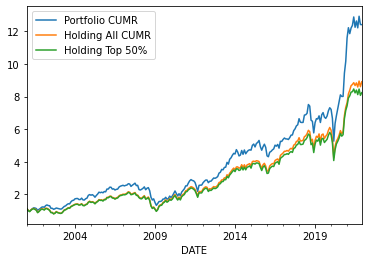

In [501]:
port_R=(1 + ret).cumprod()
holding_R= (1+ stats.groupby("DATE").mean().loc[:, "mean"]).cumprod()
holding_R2 = (1+ H2["RET"]).cumprod()
pd.DataFrame( data = {"Portfolio CUMR" : port_R, "Holding All CUMR": holding_R, "Holding Top 50%": holding_R2 }).plot()

In [253]:
port_R[len(port_R)-1] #20 years total return of our strategy

12.413348734358618

In [502]:
holding_R[len(holding_R)-1]

8.911358251827721

If we executed and invested 1 USD in our portfolio starting from 2001, the cummulative value at the end of 2021 would be 12.4 USD. The cummulative value for a long & hold equally weighted market portfolio would be 8.9 USD. The signals we choose, E/P, MOM, liquidity can generate some level of alpha before accounting for trading costs.